# Loan Payoff Classification Model Benchmark

*Benchmark for building and evaluating the best Machine Learning classification model for predicting whether a loan will be paid off or not*

## 1. Data Collection

**V1:** The dataset selected for this exercise is provided by the course material. In this dataset, each record represents a loan application which contains attributes of the loan applicant and details about the application itself, including dates, amount, and payoff status.

In this project, **IBM Watson Studio** is being utilized as the platform to manage the environment and data connections for developing machine learning models for the data. The following set of code is populated by Watson Studio to access the dataset stored on the **IBM Cloud Object Storage**.

In [81]:
# The code was removed by Watson Studio for sharing.

## 2. Data Understanding

### About dataset

This dataset is about past loans. The **Loan_train.csv** data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount                                                           |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effect                                          |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Now that the dataset has been retreived from the cloud storage, it is ready for analysis and cleaning

In [82]:
# Import libraries for exploratory data analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [83]:
# Read in data into a dataframe
loans = pd.read_csv(body)

# Preview dataframe
loans.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


**Observation:** After the dataset was transformed into a dataframe, a few transofrmations were made to the column titles. The column titled *Unnamed: 0* appears to be an additional index column in the original file, and the original index column of the dataset, which had no column header, was named as *Unnamed: 0.1*. Pandas automatically added a numeric index column when the dataframe was initialized.

### Null Values and Data Types

In [84]:
# Inspect data types and null values
loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 346 entries, 0 to 345
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      346 non-null    int64 
 1   Unnamed: 0.1    346 non-null    int64 
 2   loan_status     346 non-null    object
 3   Principal       346 non-null    int64 
 4   terms           346 non-null    int64 
 5   effective_date  346 non-null    object
 6   due_date        346 non-null    object
 7   age             346 non-null    int64 
 8   education       346 non-null    object
 9   Gender          346 non-null    object
dtypes: int64(5), object(5)
memory usage: 27.2+ KB


**Observation:** This dataset has no missing values in any of the features and consists of a variety of data types: numeric, categorical, and datetime. 

### Datetime Field Relationships

In [85]:
# Convert object type to datetime
loans['due_date'] = pd.to_datetime(loans['due_date'])
loans['effective_date'] = pd.to_datetime(loans['effective_date'])

# Create feature that represent the number of days between the loan application is due and when it is effective
loans['days_to_payoff'] = (loans['due_date'] - loans['effective_date']).dt.days + 1 # Add one since the date is inclusive
loans['num_payments'] = loans['days_to_payoff'] / loans['terms']
loans['weekday_effective'] = loans['effective_date'].dt.weekday

In [86]:
# Inspect after data type transformation
loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 346 entries, 0 to 345
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Unnamed: 0         346 non-null    int64         
 1   Unnamed: 0.1       346 non-null    int64         
 2   loan_status        346 non-null    object        
 3   Principal          346 non-null    int64         
 4   terms              346 non-null    int64         
 5   effective_date     346 non-null    datetime64[ns]
 6   due_date           346 non-null    datetime64[ns]
 7   age                346 non-null    int64         
 8   education          346 non-null    object        
 9   Gender             346 non-null    object        
 10  days_to_payoff     346 non-null    int64         
 11  num_payments       346 non-null    float64       
 12  weekday_effective  346 non-null    int64         
dtypes: datetime64[ns](2), float64(1), int64(7), object(3)
memory usag

In [87]:
# Inspect range of datetime values
loans['effective_date'].value_counts().sort_index()

2016-09-08      3
2016-09-09      8
2016-09-10     31
2016-09-11    166
2016-09-12     87
2016-09-13     20
2016-09-14     31
Name: effective_date, dtype: int64

In [88]:
loans['due_date'].value_counts().sort_index()

2016-09-16     3
2016-09-17     2
2016-09-18     3
2016-09-19     3
2016-09-22     1
2016-09-23     3
2016-09-24    12
2016-09-25    63
2016-09-26    42
2016-09-27    11
2016-09-28    10
2016-10-07     2
2016-10-08     5
2016-10-09    18
2016-10-10    90
2016-10-11    36
2016-10-12     6
2016-10-13    19
2016-10-25     4
2016-10-26     1
2016-11-09     6
2016-11-10     4
2016-11-12     2
Name: due_date, dtype: int64

In [89]:
loans['days_to_payoff'].value_counts().sort_index()

7      11
14      3
15    139
30    176
45      5
60     12
Name: days_to_payoff, dtype: int64

In [90]:
loans['num_payments'].value_counts()

1.0    322
2.0     19
3.0      5
Name: num_payments, dtype: int64

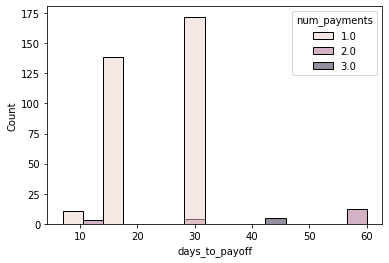

In [91]:
# Visualize the distribution of loan terms along with which ones were given different payment schedules
sns.histplot(data=loans,x='days_to_payoff',hue='num_payments', bins=15)
plt.show()

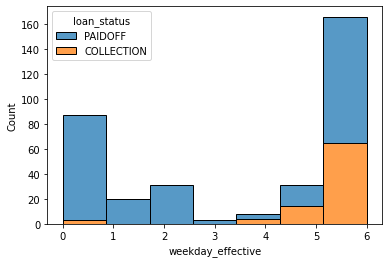

In [92]:
# Visualize the behavior of how applicants may payoff their loan depending on what day of the week they request their loan
sns.histplot(data=loans,x='weekday_effective',hue='loan_status',multiple='stack',bins=7)
plt.show()

**Observations**
* All loan applications in the dataset consist of loans that originated within the span of a week
* Of the loans made effective in that week, the due dates of these loans are given different time intervals: 1 week, 2 weeks, half a month, a month, one and a half months, or two months - with most falling into 15 or 30 days
* Loans made effective on the weekend are more likely to go into collection

### Categorical Field Values

In [93]:
# Inspect distinct values
loans['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

In [94]:
loans['Gender'].value_counts()

male      294
female     52
Name: Gender, dtype: int64

In [95]:
loans['education'].value_counts()

High School or Below    151
college                 149
Bechalor                 44
Master or Above           2
Name: education, dtype: int64

**Observations**
* The *education* attribute can be transformed to a numeric field that can range from 1 to 4, representing the levels of education in the loan applicants - since this data exhibits hierarchy due to the nature of levels in education, this is an appropriate transformation
    * **Assumption:** The value *'college'* implies some college education but not enough for a full degree program
* *loan_status* will serve as the target for the models, as this is what we want to predict 

In [96]:
# Convert gender to numerical features
gender_split = pd.get_dummies(loans['Gender'])
loans.drop(['Gender'],axis=1,inplace=True)
loans = loans.join(gender_split)

In [97]:
# Define dictionary for value mapping
education_dict = {'High School or Below':1,
                  'college':2,
                  'Bechalor':3,
                  'Master or Above':4
                 }

# Apply transformation to education field
loans['education'] = loans['education'].map(education_dict)

In [98]:
# Inspect dataframe with new features
loans.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,days_to_payoff,num_payments,weekday_effective,female,male
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,1,30,1.0,3,0,1
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,3,30,1.0,3,1,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,2,15,1.0,3,0,1
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,2,30,1.0,4,1,0
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,2,30,1.0,4,0,1


### Numeric Field Distributions

In this section, the numeric fields of the dataset will be inspected by calculating summary statistics and plotting values to spot any outliers, anomalies, and find any relationships that may exist amongst the features.

In [99]:
# Create feature of relationship between principal and term
loans['term_payment'] = loans['Principal']/loans['num_payments']

In [100]:
# Inspect statistics of numeric fields
loans.describe()

,Unnamed: 0,Unnamed: 0.1,Principal,terms,age,education,days_to_payoff,num_payments,weekday_effective,female,male,term_payment
count,346.000000,346.000000,346.000000,346.000000,346.000000,346.000000,346.000000,346.000000,346.000000,346.000000,346.000000,346.000000
mean,202.167630,202.167630,943.641618,22.653179,30.939306,1.702312,24.361272,1.083815,3.682081,0.150289,0.849711,906.840077
std,115.459715,115.459715,109.425530,7.991006,6.039418,0.706775,10.602958,0.325574,2.614912,0.357872,0.357872,163.913793
min,0.000000,0.000000,300.000000,7.000000,18.000000,1.000000,7.000000,1.000000,0.000000,0.000000,0.000000,300.000000
25%,107.250000,107.250000,900.000000,15.000000,27.000000,1.000000,15.000000,1.000000,0.250000,0.000000,1.000000,800.000000
50%,204.500000,204.500000,1000.000000,30.000000,30.000000,2.000000,30.000000,1.000000,5.000000,0.000000,1.000000,1000.000000
75%,298.750000,298.750000,1000.000000,30.000000,35.000000,2.000000,30.000000,1.000000,6.000000,0.000000,1.000000,1000.000000
max,399.000000,399.000000,1000.000000,30.000000,51.000000,4.000000,60.000000,3.000000,6.000000,1.000000,1.000000,1000.000000


**Observations**
* *Unnamed: 0* and *Unnamed: 0.1* display the same statistics - which confirms that the columns contain the same values
* *Unnamed: 0* and *Unnamed: 0.1* features have a count of 346 records but a rnage of values from 0 to 399
    * This implies that some records have been previously removed from the dataset
    * Assuming these were index columns, it can be deduced that the original dataset had 400 records and 54 records were removed
* *Principal* appears to have a right skewed distribution, where only a handful of records have small principal amounts and the rest of the loans consist of principal amounts between 900 and 1000 (assuming this is in USD)
    * With the second, third, and fourth quartile values equal to 1000, it appears that there may be a loan application, or grant, limit of 1000
* *age* consists of applicants from young adults to middle aged adults, with most applicants ranging between 18 and 35 years old
* It is very common that the *term_payment* is the full amount of the loan - *num_payments* is typically 1 payment period with few exceptions

In [101]:
# Drop unneeded columns
loans.drop(['Unnamed: 0','Unnamed: 0.1'],axis=1,inplace=True)

**Observations**
* The number of loans with a principal of 1000 is much greater than the number of loans with a term of 30 months - there appears to be a factor that allows for an applicant to have a shorter time to payoff the loan than others for the same principal amount
* There appears to be some outliers in the distribution of age of the applicants and a few loans with a principal less than 800

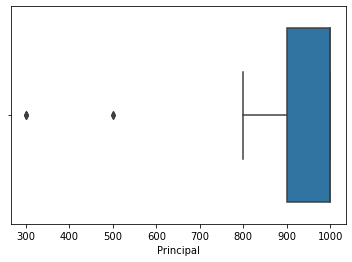

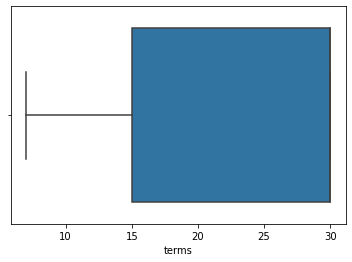

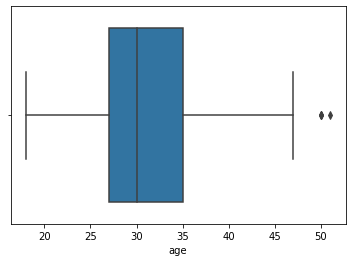

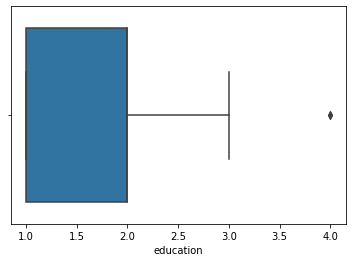

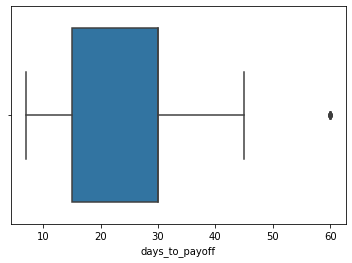

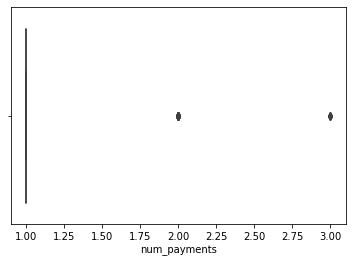

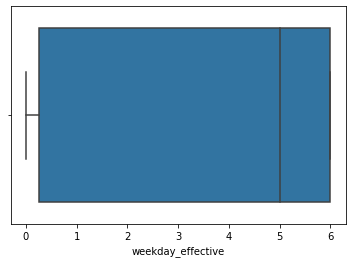

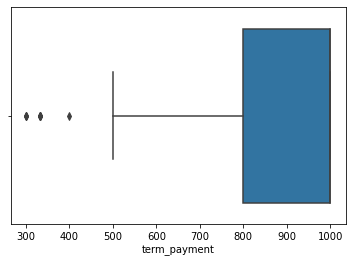

In [102]:
# Display distribution of numeric feature values
for col in loans.columns:
    if loans[col].dtype == 'int64' or loans[col].dtype == 'float64':
        sns.boxplot(x=loans[col])
        plt.show()

The records with loan prinicipal amounts less than 800 consist of only a few samples with values that are indeed at extremes in relation to the other principal amounts and are outliers. While they are outliers, they could still be included in the dataset since we wiil be feeding this data to classification algorithms, which have the capability of treating these samples accordingly - whether it be creating a separate grouping for them or a specific branch of a decision tree. Since this is a small dataset, it is important to keep as many records intact to best train the models.

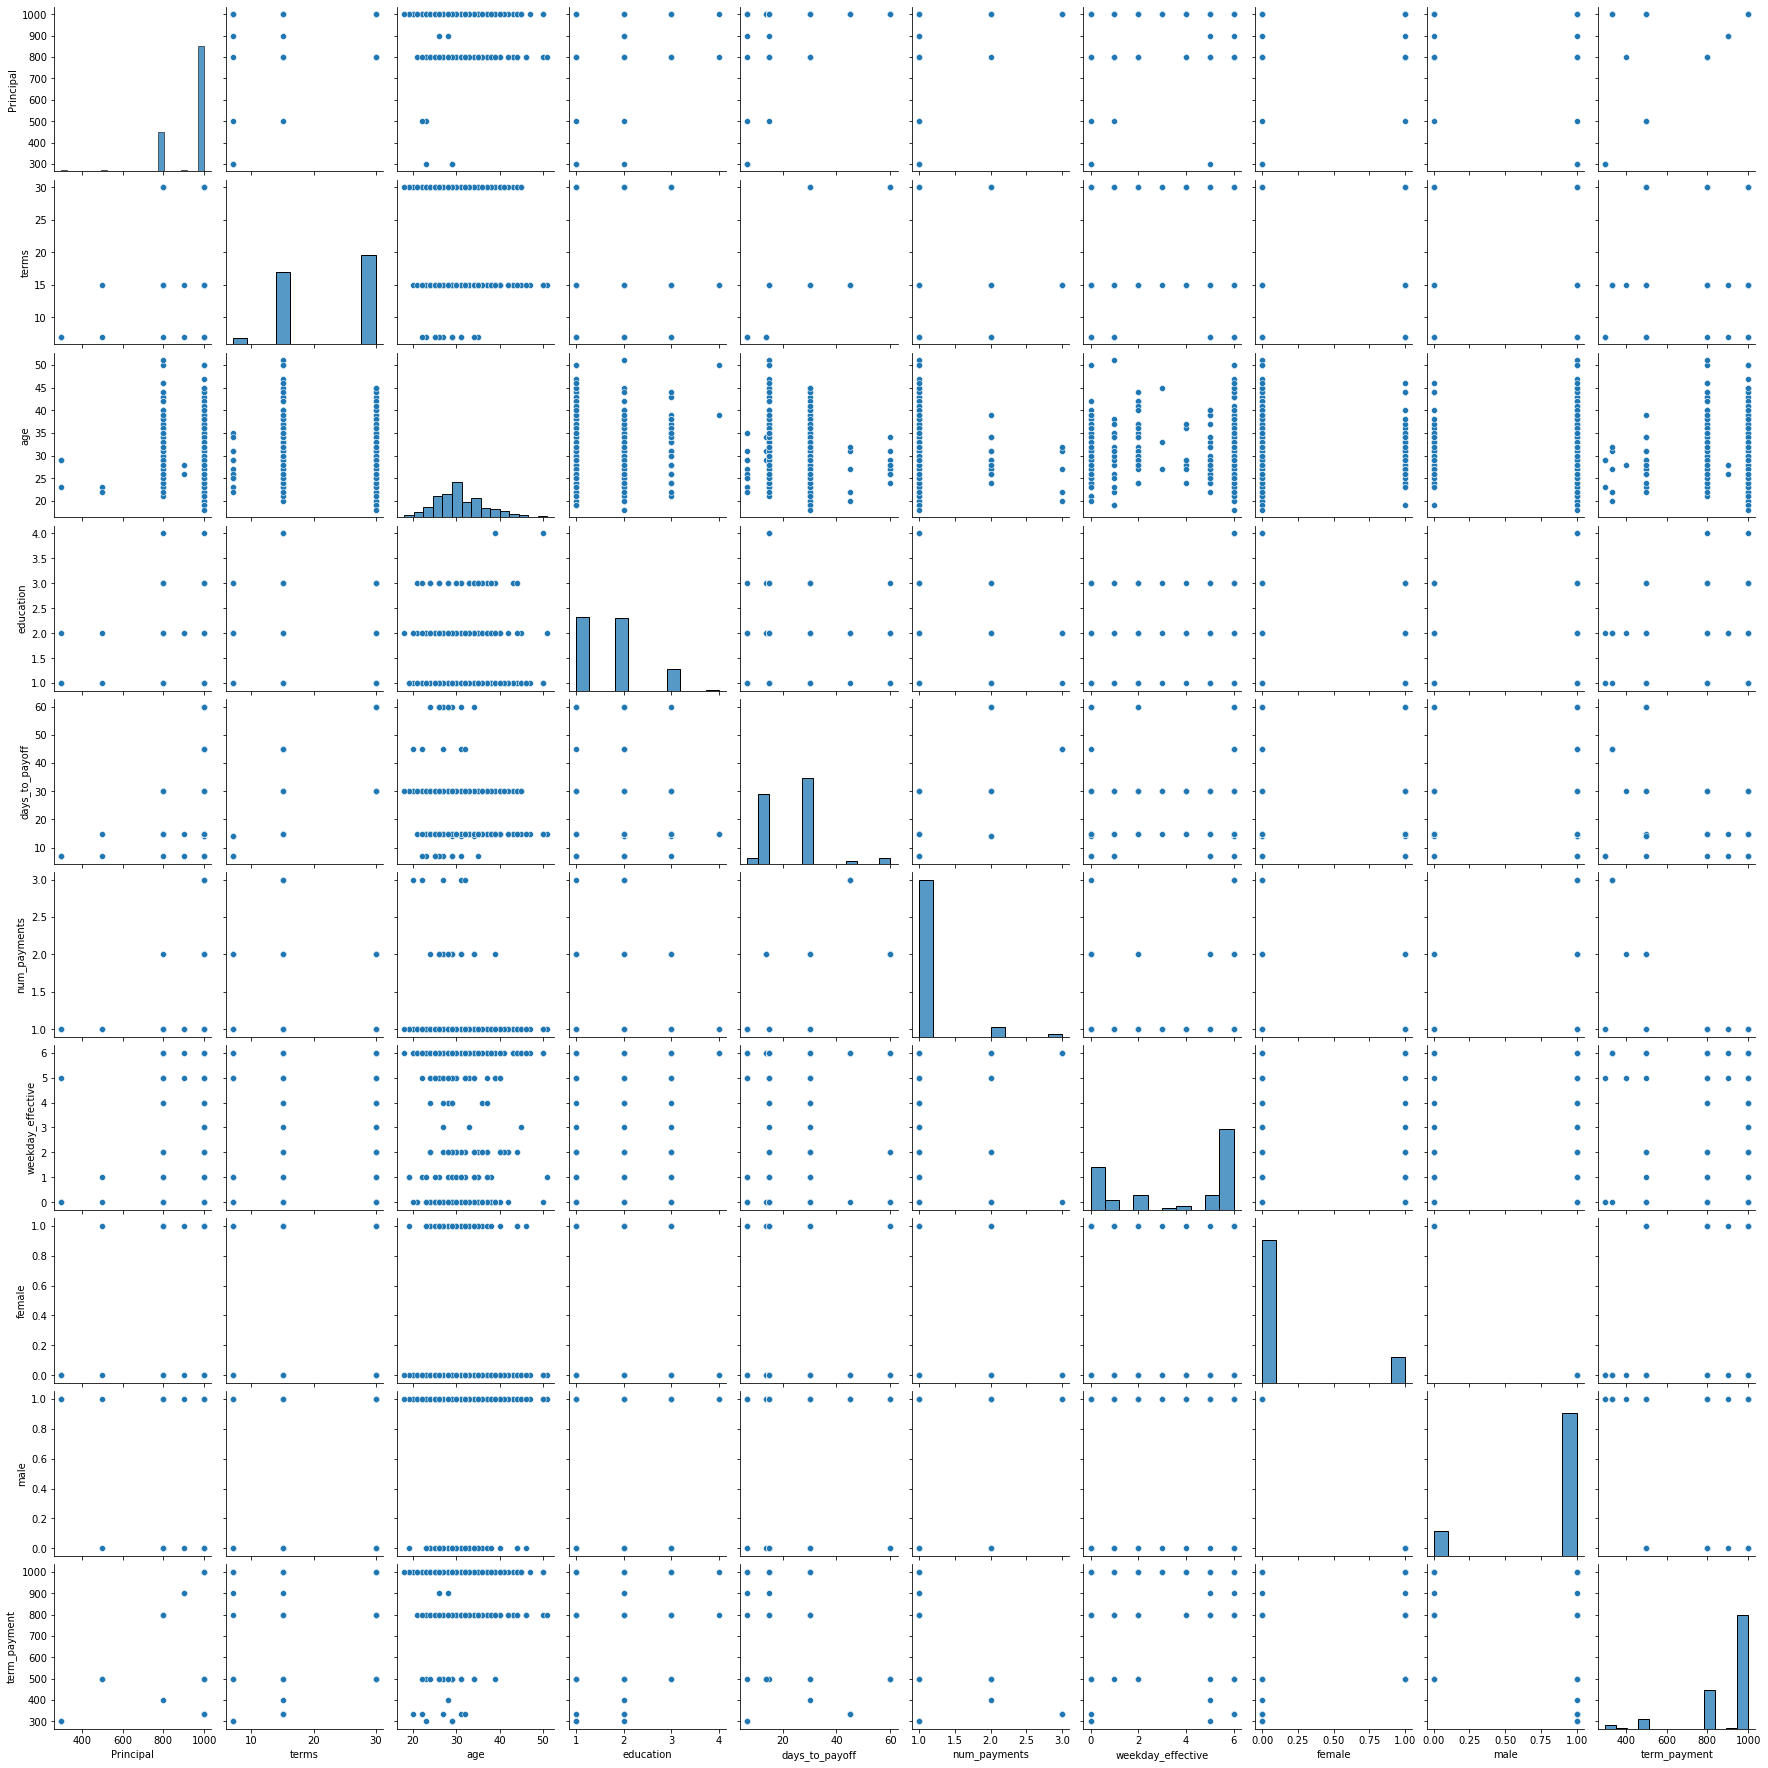

In [103]:
# Plot features against each other to view any relationships that may exist
sns.pairplot(loans)
plt.show()

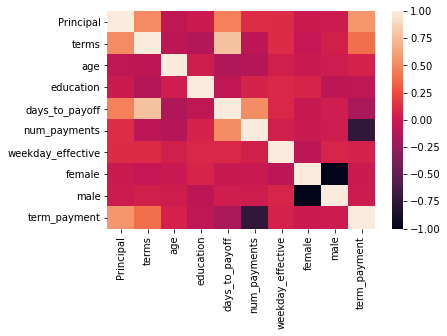

In [104]:
# Inspect correlations between features
sns.heatmap(loans.corr())
plt.show()

## 3. Data Preparation

After analyzing the data for cleanup, performing feature engineering, and transforming features to numerical values, we can now prepare the data for modeling

## 4. Modeling

## 5. Evaluation